In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#LSTM과 CNN의 조합을 이용한 IMDB 영화 리뷰 감성 분류
* 모든 단어가 아닌 빈도수 5000 까지
* 모든 문장이 아니라 100 단어까지
* Embedding 벡터는 120 차원

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.datasets import imdb

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D
from tensorflow.keras.layers import Embedding, LSTM, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
# 등장 빈도가 5,000번째까지의 단어들만 사용
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

17465344/17464789 [==============================] - 0s 0us/step


In [8]:
# 모델의 입력으로 사용하는 모든 리뷰의 길이를 동일하게 100으로 맞춤
max_len=100
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [9]:
# LSTM, CNN 모델
model = Sequential()
model.add(Embedding(5000, 120))
model.add(Dropout(0.5)) 
model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 120)         600000    
_________________________________________________________________
dropout (Dropout)            (None, None, 120)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 55)                26400     
_________________________________________________________________
dense (Dense)                (None, 1)                 56        
Total params: 664,920
Trainable params: 664,920
Non-trainable params: 0
__________________________________________________

In [10]:
# 모델의 컴파일
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
modelpath = "model/imdb-lstm-cnn-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [12]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


In [13]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10,
                    batch_size=64, callbacks=[checkpointer], verbose = 1)

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.7871
Epoch 00001: val_loss improved from inf to 0.32724, saving model to model/imdb-lstm-cnn-01-0.3272.hdf5
391/391 [==============================] - 11s 27ms/step - loss: 0.4260 - accuracy: 0.7871 - val_loss: 0.3272 - val_accuracy: 0.8565
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.2824 - accuracy: 0.8820
Epoch 00002: val_loss improved from 0.32724 to 0.32127, saving model to model/imdb-lstm-cnn-02-0.3213.hdf5
391/391 [==============================] - 10s 25ms/step - loss: 0.2824 - accuracy: 0.8820 - val_loss: 0.3213 - val_accuracy: 0.8595
Epoch 3/10
390/391 [============================>.] - ETA: 0s - loss: 0.2334 - accuracy: 0.9076
Epoch 00003: val_loss did not improve from 0.32127
391/391 [==============================] - 10s 25ms/step - loss: 0.2335 - accuracy: 0.9076 - val_loss: 0.3305 - val_accuracy: 0.8584
Epoch 4/10
391/391 [==============================] 

In [14]:
# Best Model 선택
from tensorflow.keras.models import load_model
# del model
model = load_model('model/imdb-lstm-cnn-02-0.3213.hdf5')

In [15]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test, verbose=2)[1]))

782/782 - 4s - loss: 0.3213 - accuracy: 0.8595

 테스트 정확도: 0.8595


In [16]:
# 테스트셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

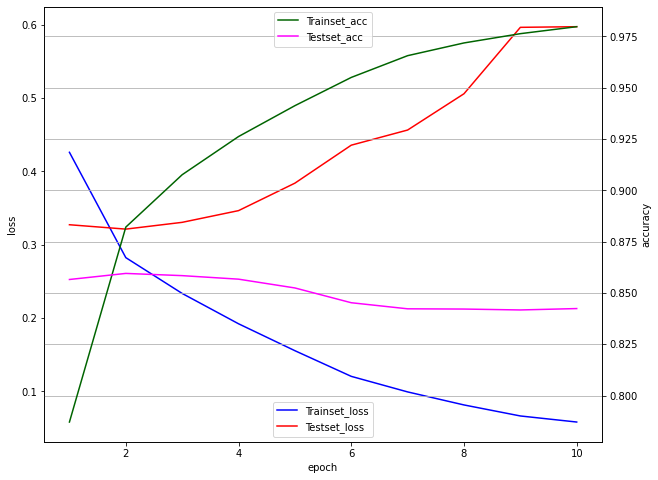

In [17]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='Trainset_loss')
ax0.plot(x_len, y_vloss, c="red", label='Testset_loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='Trainset_acc')
ax1.plot(x_len, y_vacc, c="magenta", label='Testset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()